Our goal is to determine the salary based on the other metrics.

### 1 - Importing Libraries

In [1]:
# Standard libraries
import os
import re # regex

# Data Analysis + Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import HistGradientBoostingRegressor

### 2 - Loading Dataset

In [2]:
df = pd.read_csv("/kaggle/input/data-science-job-postings-with-salaries-2025/data_science_job_posts_2025.csv")
df.head()

,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
0,data scientist,senior,hybrid,company_003,"Grapevine, TX . Hybrid",17 days ago,"Bentonville, AR, US",Retail,Public,€352.44B,Public,"€100,472 - €200,938","['spark', 'r', 'python', 'scala', 'machine lea..."
1,data scientist,lead,hybrid,company_005,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030",€51.10B,"€118,733","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,company_007,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930",€33.80B,"€94,987 - €159,559","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,company_008,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690",€81.71B,"€112,797 - €194,402","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,company_009,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"€114,172 - €228,337",[]


### 3 - Data Exploration

From this data exploration we can see that there are:

* 13 columns of data
* 944 rows of data
* 0 duplicated values
* various rows in null values

In [3]:
cols = df.columns.tolist()
print("Columns in dataset:", cols)

# Shape of the dataset (rows, columns)
print("Shape: " + str(df.shape))

# Data types
df.info

print("Number of null values: \n"+ str(df.isnull().sum()))
print("Number of duplicated values: "+ str(df.duplicated().sum()))

Columns in dataset: ['job_title', 'seniority_level', 'status', 'company', 'location', 'post_date', 'headquarter', 'industry', 'ownership', 'company_size', 'revenue', 'salary', 'skills']
Shape: (944, 13)
Number of null values: 
job_title            3
seniority_level     60
status             256
company              0
location             2
post_date            0
headquarter          0
industry             0
ownership           47
company_size         0
revenue             15
salary               0
skills               0
dtype: int64
Number of duplicated values: 0


### 4 - Data Cleaning



According to the dataset, 'status' describes whether the jobs is:

1. on-site
2. hybrid
3. remote

In total, we are missing 381 values. This means the number of complete rows is between 563 and 688. Let's check how many rows there are if we drop a row with a missing value:

In [4]:
len_df = len(df)
df_drop_missing = df.dropna()
len_df_drop_missing = len(df_drop_missing)

print("len_df: " + str(len_df) + ", len_dfc: " + str(len_df_drop_missing))

len_df: 944, len_dfc: 599


We can see there's a significant drop in data if we drop all our missing rows. Let's try changing missing 'status' values to 'Unknown', and then check the difference between df and dfc!

In [5]:
dfc = df.copy()
dfc['status'] = dfc['status'].fillna('Unknown')
dfc.isnull().sum()

job_title           3
seniority_level    60
status              0
company             0
location            2
post_date           0
headquarter         0
industry            0
ownership          47
company_size        0
revenue            15
salary              0
skills              0
dtype: int64

Great, we've changed the "NaN" values in 'status' to "Unknown". Now, we can drop the other empty rows.

In [6]:
dfc.dropna(inplace=True)
len(dfc)

834

After dropping the other rows with an empty value, we have 834 complete rows that we can infer from. Through manually inspecting the data, we can see that salaries either:

(i) as a range with the following formatting: 
€xxx, xxx - €xxx, xxx

(ii) as a static number with the following formatting:
€xxx, xxx

For ranges, we should take the average value using the following formula: (max - min) / 2

We will also strip the whitespace and remove the commas to get static numbers as such:

€xxxxxx

After, we will convert € (EUR) -> $ (CAD) with the current conversion rate: 1 EUR = 1.62 CAD (as of Sept. 9th, 2025)

In [7]:
s = df['salary'].astype(str)

# normalize formatting for s
s = (s.str.replace('\u00a0', '', regex=False) # NBSP
      .str.replace('\u202f', '', regex=False) # narrow NBSP
      .str.replace(',', '', regex=False)      # commas
      .str.strip())

# extract ranges
pat_range = re.compile(r"""
    €\s*             # euro sign + optional whitespace
    ([\d\s\.]+)      # first number (digits/space/dots)
    \s*[-–]\s*       # dash (en or hyphen) with optional spaces
    €?               # optional second euro sign
    \s*([\d\s\.]+)  # second number
""", re.VERBOSE)

rng = s.str.extract(pat_range) # cols: 0 (low), 1 (high)

# cleaning ranging salaries -> to numeric
to_num = lambda x: pd.to_numeric(x.str.replace(r'[\s\.\,]+', '', regex=True), # drop all whitespace
                                 errors='coerce' # convert to numbers; error = NaN
                                )
low = to_num(rng[0])
high = to_num(rng[1])

# get the average for ranging salaries
avg_range = (low + high) / 2
mask_range = avg_range.notna()

# extract cleaned single values
single = s[~mask_range].str.extract(r'€\s*([\d\s\.]+)')[0]
single = to_num(single)

# combine
df.loc[mask_range, 'salary_eur'] = avg_range[mask_range]
df.loc[~mask_range, 'salary_eur'] = single

# convert 'salary_eur' to 'salary_cad'
EUR_TO_CAD = 1.62 # conversion rate
df['salary_cad'] = df['salary_eur'] * EUR_TO_CAD

In [8]:
# check the results
print("Ranges parsed:", mask_range.sum())
print("Singles parsed:", single.notna().sum())
df[['salary','salary_eur','salary_cad']].head()

Ranges parsed: 594
Singles parsed: 350


,salary,salary_eur,salary_cad
0,"€100,472 - €200,938",150705.0,244142.10
1,"€118,733",118733.0,192347.46
2,"€94,987 - €159,559",127273.0,206182.26
3,"€112,797 - €194,402",153599.5,248831.19
4,"€114,172 - €228,337",171254.5,277432.29


Great! Now, we have salaries in CAD, and no empty cells!

### 5 - Exploratory Data Analysis (EDA)

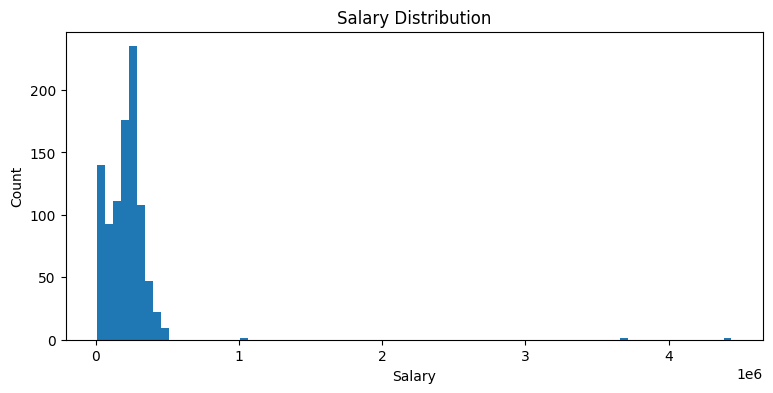

In [9]:
plt.figure(figsize=(9,4))
plt.hist(df['salary_cad'], bins=80)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.show()

Our salary is very skewed due to only a few extremely high salaries (very lucky!). Let's log-transform 'salary_cad' to get a more normal distribution:

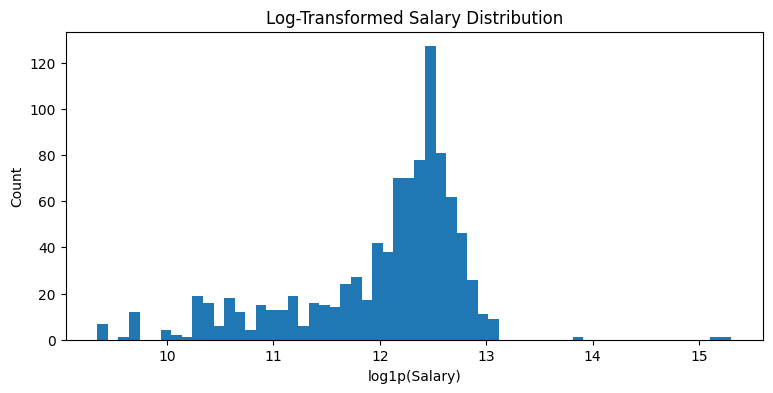

In [10]:
# take the natural log of 'salary_cad'
df['salary_cad_log'] = np.log(df['salary_cad'])

plt.figure(figsize=(9,4))
plt.hist(df['salary_cad_log'], bins=60)
plt.title('Log-Transformed Salary Distribution')
plt.xlabel('log1p(Salary)')
plt.ylabel('Count')
plt.show()

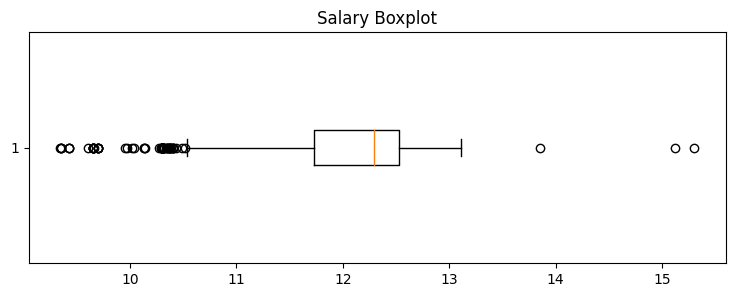

{'Q1_log': 11.725794291605215,
 'Median_log': 12.293409669484184,
 'Q3_log': 12.524408042374757,
 'IQR_log': 0.7986137507695421,
 'LowerFence_log': 10.527873665450901,
 'UpperFence_log': 13.72232866852907,
 'Outliers_count': 67,
 'Q1_CAD': 123722.23499801154,
 'Median_CAD': 218252.8799984966,
 'Q3_CAD': 274967.4600000001}

In [11]:
plt.figure(figsize=(9,3))
plt.boxplot(df['salary_cad_log'], vert=False)
plt.title('Salary Boxplot')
plt.show()

x = df['salary_cad_log'].dropna()

q1, med, q3 = x.quantile([0.25, 0.5, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
n_out = ((x < lower) | (x > upper)).sum()

summary = {
    "Q1_log": q1, "Median_log": med, "Q3_log": q3, "IQR_log": iqr,
    "LowerFence_log": lower, "UpperFence_log": upper,
    "Outliers_count": int(n_out),
    "Q1_CAD": np.exp(q1), "Median_CAD": np.exp(med), "Q3_CAD": np.exp(q3)
}
summary

### 6 - Data Engineering

In [12]:
# -- Title
df['title_clean'] = df['job_title'].fillna('Unknown').str.strip().str.title()
title_dummies = pd.get_dummies(df['title_clean'], prefix='title', dummy_na=False)
df = pd.concat([df, title_dummies], axis=1)

# -- Status --
df['status_clean'] = df['status'].fillna('Unknown').str.strip().str.title()
status_dummies = pd.get_dummies(df['status_clean'], prefix='status', dummy_na=False)
df = pd.concat([df, status_dummies], axis=1)
df['is_remote'] = df['status_clean'].str.contains(r'\bRemote\b', case=False)

# -- Location --
loc = df['location'].fillna('Unknown').astype(str)

# flags
df['is_fully_remote'] = loc.str.contains(r'fully\s*remote|remote', case=False, regex=True)

# -- Country --
country = (loc.str.split(',')
          .apply(lambda parts: parts[-1].strip().title() if len(parts) else 'Unknown'))
country = country.replace('', 'Unknown')
df['country'] = country

# -- Post Date --
def age_in_days(s: str):
    if not isinstance(s, str):
        return np.nan
    m = re.search(r'(\d+)\s*(day|week|month|year)s?\s*ago', s.lower())
    if not m:
        return np.nan
    n = int(m.group(1))
    unit = m.group(2)
    factor = {'day':1, 'week':7, 'month':30.44, 'year':365.25}.get(unit, np.nan)
    return n * factor

df['post_age_days'] = df['post_date'].apply(age_in_days)

# -- Industry --
K_INDUSTRIES = 20
ind = df['industry'].fillna('Unknown').astype(str).str.strip().str.title()
top_inds = ind.value_counts().nlargest(K_INDUSTRIES).index
df['industry_topk'] = np.where(ind.isin(top_inds), ind, 'Other')
ind_dummies = pd.get_dummies(df['industry_topk'], prefix='industry')
df = pd.concat([df, ind_dummies], axis=1)

# -- Ownership -- (Public/Private/NaN)
own = df['ownership'].fillna('Unknown').astype(str).str.strip().str.title()
own_dummies = pd.get_dummies(own, prefix='own')
df = pd.concat([df, own_dummies], axis=1)

# -- Company Size -> bins
def size_to_bin(s):
    if pd.isna(s): return 'Unknown'
    t = str(s).replace(',', '')
    nums = list(map(int, re.findall(r'\d+', t)))
    if not nums: return 'Unknown'
    mx = max(nums)
    if mx < 50: return 'small'
    if mx < 200: return 'medium'
    return 'large'

df['company_size_bin'] = df['company_size'].apply(size_to_bin)
size_dummies = pd.get_dummies(df['company_size_bin'], prefix='size')
df = pd.concat([df, size_dummies], axis=1)

# -- Company
df = df.drop(columns=['company'], errors='ignore')

The 'Revenue' feature will take a bit more work. Currently, the data in 'Revenue' is structured as:
* Private
* Public
* €xxx.xxB
* €xxx.xxM

In [13]:
# ---- Revenue

rev = df['revenue'].astype(str).str.strip()

# normalize spaces/commas so parsing is easier
rev = (rev.str.replace('\u00a0', ' ', regex=False)       # NBSP
          .str.replace('\u202f', ' ', regex=False)        # narrow NBSP
          .str.replace(',', '', regex=False)              # remove commas
          .str.replace(r'\s+', ' ', regex=True)
          .str.strip())

# -------- 1) ownership labels that appear in revenue
mask_own = rev.str.fullmatch(r'(?i)public|private')

# start from existing ownership (if present); otherwise Unknown
df['ownership_clean'] = df.get('ownership', pd.Series(index=df.index, dtype=object)).fillna('Unknown')

# fill ownership from revenue where ownership is Unknown
df.loc[df['ownership_clean'].eq('Unknown') & mask_own, 'ownership_clean'] = rev[mask_own].str.title()

# -------- 2) parse numeric revenue like €61.06B / €913.33M / €55.54B
# capture number and unit (B/M/K or words)
m = rev.str.extract(r'(?i)€?\s*([\d.]+)\s*(b|m|k|bn|billion|million|mio)?')

num  = pd.to_numeric(m[0], errors='coerce')
unit = m[1].str.lower().fillna('')

mult = unit.map({
    'b': 1e9, 'bn': 1e9, 'billion': 1e9,
    'm': 1e6, 'million': 1e6, 'mio': 1e6,
    'k': 1e3
}).fillna(1.0)

df['revenue_eur'] = num * mult

# revenue cells that were ownership labels (and pure text like 'Education') -> NaN
mask_pure_text = rev.str.fullmatch(r'(?i)[a-z\s]+')   # only letters/spaces
df.loc[mask_own | mask_pure_text, 'revenue_eur'] = np.nan

We also can process the 'headquarters' feature:

In [14]:
# Only create if missing
if 'hq_country' not in df.columns:
    def extract_hq_country(s):
        if pd.isna(s):
            return 'UNKNOWN'
        # expected format: "City, [State/Prov], CountryCode"
        parts = str(s).split(',')
        c = parts[-1].strip().upper().replace('.', '')
        # normalize a few common aliases
        aliases = {
            'USA':'US', 'UNITED STATES':'US', 'U S':'US', 'U S A':'US',
            'UK':'GB', 'U K':'GB', 'UNITED KINGDOM':'GB',
            'CAN':'CA', 'CANADA':'CA'
        }
        return aliases.get(c, c if c else 'UNKNOWN')

    if 'headquarter' in df.columns:
        df['hq_country'] = df['headquarter'].apply(extract_hq_country)
    else:
        # skip HQ features if there's no 'headquarter' column
        df['hq_country'] = 'UNKNOWN'

# Now your dummies:
K_COUNTRIES = 15
hq_raw = df['hq_country'].fillna('UNKNOWN').astype(str).str.upper()
top_hq = hq_raw.value_counts().nlargest(K_COUNTRIES).index
df['hq_country_topk'] = np.where(hq_raw.isin(top_hq), hq_raw, 'OTHER')
hq_dum = pd.get_dummies(df['hq_country_topk'], prefix='hq_country')

# (Re)attach dummies cleanly
old_hq = [c for c in df.columns if c.startswith('hq_country_') and c != 'hq_country_topk']
df = pd.concat([df.drop(columns=old_hq, errors='ignore'), hq_dum], axis=1)


In [15]:
# log-transform the big count so it doesn't dominate purely by scale
if 'hq_location_count' in df.columns:
    df['hq_location_count'] = np.log1p(df['hq_location_count'])

# job COUNTRY → top-K dummies + "OTHER"
K_COUNTRIES = 15
country_raw = df['country'].fillna('Unknown').astype(str).str.upper()
top_cty = country_raw.value_counts().nlargest(K_COUNTRIES).index
df['country_topk'] = np.where(country_raw.isin(top_cty), country_raw, 'OTHER')
country_dum = pd.get_dummies(df['country_topk'], prefix='country')

# HQ COUNTRY → top-K dummies + "OTHER"
hq_raw = df['hq_country'].fillna('Unknown').astype(str).str.upper()
top_hq = hq_raw.value_counts().nlargest(K_COUNTRIES).index
df['hq_country_topk'] = np.where(hq_raw.isin(top_hq), hq_raw, 'OTHER')
hq_dum = pd.get_dummies(df['hq_country_topk'], prefix='hq_country')

# drop any old country/hq_country dummies so we don't duplicate
old_country = [c for c in df.columns if c.startswith('country_') and c not in ['country_topk']]
old_hq      = [c for c in df.columns if c.startswith('hq_country_') and c not in ['hq_country_topk']]
df = df.drop(columns=old_country + old_hq, errors='ignore')

# attach the new dummies
df = pd.concat([df, country_dum, hq_dum], axis=1)

Let's also process the various skills that appear in the dataset:

In [16]:
import ast, re
from collections import Counter

def parse_skills(cell):
    if pd.isna(cell): return []
    t = str(cell).strip()
    try:
        # Handles "['Python', 'SQL']"
        items = ast.literal_eval(t) if t.startswith('[') and t.endswith(']') else re.split(r'[,\|;/]+', t)
    except Exception:
        items = re.split(r'[,\|;/]+', t)
    cleaned = []
    for x in items:
        x = (str(x).lower().strip()
                .strip("'\"[]()")                       # drop stray quotes/brackets
                .replace('\u00a0',' '))
        x = re.sub(r'\s+', ' ', x)
        x = re.sub(r'[^a-z0-9+.#\-\s]', '', x)         # keep sane chars
        if x: cleaned.append(x)
    return cleaned

# normalize common variants
SYN = {'scikit learn':'sklearn','scikit-learn':'sklearn','power bi':'powerbi',
       'ms excel':'excel','node js':'nodejs','c plus plus':'c++',
       'machine learning':'machine_learning'}
skills_list = df['skills'].apply(parse_skills).apply(lambda xs: [SYN.get(s,s) for s in xs])

# keep only skills with enough support
MIN_SUPPORT = 10
cnt = Counter(s for xs in skills_list for s in xs)
keep = {s for s,c in cnt.items() if c >= MIN_SUPPORT}

# one-hots + counts
for s in sorted(keep):
    df[f"skill_{s.replace(' ','_')}"] = skills_list.apply(lambda xs, s=s: int(s in xs))
df['n_skills']        = skills_list.apply(len)
df['n_topk_skills']   = df.filter(like='skill_').sum(axis=1)
df['n_other_skills']  = df['n_skills'] - df['n_topk_skills']

After finishing preparing all of our data, we can move onto the modelling stage.

### 7 - Modelling

Let's define our target:

In [17]:
y = df['salary_cad_log'].copy()

In Section 6, we created a variety of new features that we will use throughout the modeling phase. However, we do not want to include some of our old features, or features that will not contribute properly towards our modelling.

In [18]:
ban = {'salary', 'salary_eur', 'salary_cad', 'salary_cad_log', 'salary_cad_log_capped',
    'post_date', 'job_title', 'title_clean', 'status', 'status_clean',
    'location', 'industry', 'industry_topk', 'company', 'company_size',
    'headquarter', 'revenue', 'ownership', 'country'}

num_bool = df.select_dtypes(include=['number', 'bool']).columns
feature_cols = [c for c in num_bool if c not in ban]

X = df[feature_cols].copy()

Now we can begin training and testing our model.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

# Baseline
dummy = DummyRegressor(strategy='median').fit(X_train, y_train)

def eval_model(m, name):
    yhat_log = m.predict(X_valid)
    # Duan smearing
    resid = y_train - m.predict(X_train)
    smear = float(np.mean(np.exp(resid)))
    yhat = np.exp(yhat_log) * smear
    mae_log = mean_absolute_error(y_valid, yhat_log)
    mae_cad = mean_absolute_error(np.exp(y_valid), yhat)
    print(f"{name:28s} MAE_log={mae_log:,.4f}      MAE_CAD={mae_cad:,.0f}")
    return smear

In [20]:
_ = eval_model(dummy, "Dummy (median)")

Dummy (median)               MAE_log=0.5339      MAE_CAD=83,720


In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor
gbr = HistGradientBoostingRegressor(
    loss="absolute_error", learning_rate=0.05, max_iter=500, random_state=42
).fit(X_train, y_train)
_ = eval_model(gbr, "HGBR (MAE loss)")

HGBR (MAE loss)              MAE_log=0.2763      MAE_CAD=48,762


We can see that HGBR performs better than our dummy model, which represents the median. MAE_CAD = 48,854 can be interpreted as the absolute error of our salary estimations, which is smaller compared to the median salary_cad of $218,252.

Let's fine-tune our HGBR model to see if we can get an even better estimate.

In [22]:
def eval_hgbr(params):
    m = HistGradientBoostingRegressor(
        loss="absolute_error",
        random_state=42,
        **params
    ).fit(X_train, y_train)
    # smearing on train
    smear = float(np.mean(np.exp(y_train - m.predict(X_train))))
    yhat = np.exp(m.predict(X_valid)) * smear
    mae = mean_absolute_error(np.exp(y_valid), yhat)
    return mae, m, smear

grid = [
    {"learning_rate": lr, "max_leaf_nodes": mln, "min_samples_leaf": msl, "l2_regularization": l2, "max_iter": 600}
    for lr in [0.03, 0.05, 0.08]
    for mln in [31, 63, 127]
    for msl in [10, 20, 50]
    for l2 in [0.0, 0.3, 1.0]
]

best = None
for p in grid:
    mae, m, smear = eval_hgbr(p)
    if (best is None) or (mae < best[0]):
        best = (mae, p, m, smear)

print("Best MAE_CAD:", round(best[0], 0), "with params:", best[1])
best_model, best_smear = best[2], best[3]

Best MAE_CAD: 45558.0 with params: {'learning_rate': 0.08, 'max_leaf_nodes': 31, 'min_samples_leaf': 10, 'l2_regularization': 0.3, 'max_iter': 600}


In [23]:
from sklearn.inspection import permutation_importance
imp = permutation_importance(gbr, X_valid, y_valid, n_repeats=5, random_state=42)
fi = (pd.Series(imp.importances_mean, index=X.columns)
        .sort_values(ascending=False).head(20))
print(fi)

country_INDIA             0.872767
country_OTHER             0.119019
hq_country_US             0.087501
status_Hybrid             0.072895
revenue_eur               0.054495
n_skills                  0.034523
country_CA . HYBRID       0.034008
own_Unknown               0.026510
status_On-Site            0.026193
skill_machine_learning    0.015526
own_Private               0.013377
own_Public                0.011668
post_age_days             0.009472
industry_Technology       0.006971
industry_Finance          0.004268
skill_deep_learning       0.004138
skill_r                   0.003643
country_CA                0.003280
skill_numpy               0.003130
status_Remote             0.003071
dtype: float64


In [24]:
import shap

# 1) Build a numeric copy for SHAP (booleans -> ints; everything -> float32/64)
num_cols  = X_train.columns  # X_train already only has numeric/boolean features, right?
Xtr_shap  = X_train[num_cols].copy()
Xva_shap  = X_valid[num_cols].copy()

# cast bools to 0/1 so the whole frame becomes numeric
bool_cols = Xtr_shap.select_dtypes(include='bool').columns
Xtr_shap[bool_cols] = Xtr_shap[bool_cols].astype(np.int8)
Xva_shap[bool_cols] = Xva_shap[bool_cols].astype(np.int8)

# replace infs; SHAP dislikes them
Xtr_shap = Xtr_shap.replace([np.inf, -np.inf], np.nan)
Xva_shap = Xva_shap.replace([np.inf, -np.inf], np.nan)

# optional: fill NaNs only for the SHAP background (model was trained with NaNs fine)
bg = shap.sample(Xtr_shap.fillna(Xtr_shap.median(numeric_only=True)), 200)  # small background speeds up

# 2) Create the explainer with a numeric masker
masker = shap.maskers.Independent(bg)
expl   = shap.Explainer(gbr, masker, feature_names=Xtr_shap.columns)

# 3) Compute SHAP values on the numeric validation set
sv = expl(Xva_shap, check_additivity=False)   # sv.values shape: (n_valid, n_features)

In [25]:
def top_positive_binary(prefix, Xv=Xva_shap, sv=sv, top=15, min_n=20):
    rows = []
    for col in [c for c in Xv.columns if c.startswith(prefix)]:
        j = Xv.columns.get_loc(col)
        present = Xv[col] == 1
        n = int(present.sum())
        if n < min_n: 
            continue
        mean_shap = sv.values[present, j].mean()         # log-scale effect
        pct = (np.exp(mean_shap) - 1.0) * 100.0          # convert to %
        rows.append((col, n, mean_shap, pct))
    return (pd.DataFrame(rows, columns=['feature','n_present','mean_shap','pct_effect_%'])
            .sort_values('mean_shap', ascending=False)
            .head(top))

top_skills_up   = top_positive_binary('skill_', top=20, min_n=20)
top_country_up  = top_positive_binary('country_', top=15, min_n=20)

print(top_skills_up)
print(top_country_up)

                   feature  n_present  mean_shap  pct_effect_%
7                  skill_r         65   0.028944      2.936729
2      skill_deep_learning         29   0.023496      2.377373
8              skill_spark         30   0.020729      2.094510
11        skill_tensorflow         26   0.015523      1.564409
3                skill_gcp         21   0.014409      1.451316
5             skill_python        123   0.005206      0.521966
0                skill_aws         38   0.003116      0.312084
10           skill_tableau         26   0.002338      0.234087
4   skill_machine_learning        112  -0.014987     -1.487520
6            skill_pytorch         22  -0.015136     -1.502241
9                skill_sql         82  -0.018275     -1.810921
1              skill_azure         27  -0.028209     -2.781488
         feature  n_present  mean_shap  pct_effect_%
0     country_CA         21   0.060406      6.226738
2  country_OTHER         91  -0.000390     -0.038998
1  country_INDIA      

From this, we can see that the Canadian job postings have about 6% higher salary than other countries, and the top 3 skills (according to salary increase) are:

* R Programming - 2.94% increase
* Deep Learning - 2.38% increase
* Spark - 2.09% increase

This concludes the first edition of the Salary Predictor.